In [1]:
from Funcs.Utility import *
import numpy as np
import pandas as pd
from typing import Dict, Callable, Union, Tuple, List, Optional, Iterable, Any
from datetime import timedelta as td
from scipy import stats
import ray
import warnings
import time

In [2]:
import numpy as np
import pandas as pd
from scipy import stats as sp
from scipy.signal import correlate
from sklearn.preprocessing import StandardScaler
from functools import reduce
import matplotlib.pyplot as plt
import seaborn as sns
import logging
from typing import Dict, List


# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger()

In [3]:
def extract_numeric_features(window_data: np.ndarray) -> Dict[str, float]:
    if len(window_data) < 2 or np.isnan(window_data).all():
        logger.debug("Window data is insufficient or contains all NaN values.")
        return {}
    features = {}
    try:
        # Remove NaN values
        window_data = window_data[~np.isnan(window_data)]
        logger.debug(f"Window data after removing NaNs: {window_data}")
        
        if len(window_data) < 2:
            logger.debug("After removing NaNs, window data is insufficient.")
            return {}
        
        features['MED'] = np.median(window_data)
        features['MIN'] = np.min(window_data)
        features['MAX'] = np.max(window_data)
        features['AVG'] = np.mean(window_data)
        features['VAR'] = np.var(window_data, ddof=1)
        if features['VAR'] == 0:
            features['SKW'] = 0
            features['KUR'] = 0
        else:
            features['SKW'] = sp.skew(window_data, bias=False)
            features['KUR'] = sp.kurtosis(window_data, bias=False)
        features['ASC'] = np.sum(np.abs(np.diff(window_data)))
        
        # Binned Entropy (n = 10)
        hist, _ = np.histogram(window_data, bins=10, density=False)
        features['BEP'] = sp.entropy(hist)
        
        # Auto-correlation Features using scipy.signal.correlate
        acf = correlate(window_data - np.mean(window_data), window_data - np.mean(window_data), mode='full')
        acf = acf[len(acf)//2:]
        if len(acf) > 1:
            features['MAXLAG'] = np.argmax(acf[1:]) + 1  # exclude zero lag
            features['MAXLAGVAL'] = np.max(acf[1:])
            features['MINLAG'] = np.argmin(acf[1:]) + 1
            features['MINLAGVAL'] = np.min(acf[1:])
        else:
            features['MAXLAG'] = 0
            features['MAXLAGVAL'] = 0
            features['MINLAG'] = 0
            features['MINLAGVAL'] = 0
        
        # Linear Trend
        slope, intercept, _, _, _ = sp.linregress(np.arange(len(window_data)), window_data)
        features['LTS'] = slope
        features['LTI'] = intercept
        
        # Time-series Complexity
        std_dev = np.std(window_data)
        if std_dev != 0:
            norm_x = (window_data - np.mean(window_data)) / std_dev
        else:
            norm_x = np.zeros(len(window_data))
        features['CID'] = np.sqrt(np.sum(np.diff(norm_x) ** 2))
        
    except Exception as e:
        logger.error(f"Error extracting numeric features: {e}")
    
    return features

In [4]:
def extract_nominal_features(window_data: np.ndarray, is_bounded: bool) -> Dict[str, float]:
    if len(window_data) == 0:
        return {}
    features = {}
    try:
        unique_values, counts = np.unique(window_data, return_counts=True)
        entropy = sp.entropy(counts)
        features['ETP'] = entropy
        features['ASC'] = np.sum(window_data[1:] != window_data[:-1])
        
        if is_bounded:
            support_features = {f'SUP:{val}': count for val, count in zip(unique_values, counts)}
            features.update(support_features)
    except Exception as e:
        logger.error(f"Error extracting nominal features: {e}")
        
    return features

def impute_support_features(df: pd.DataFrame) -> pd.DataFrame:
    support_features = df.columns[df.columns.str.startswith('SUP:')]
    df[support_features] = df[support_features].fillna(0)
    return df

def sliding_window_feature_extraction(
    combined_df: pd.DataFrame,
    window_size_minutes: int,
    step_size_minutes: int = None,
    selected_features: List[str] = None
) -> pd.DataFrame:
    if step_size_minutes is None:
        step_size_minutes = window_size_minutes  # Default to non-overlapping windows
    
    extracted_features = []
    
    # Ensure the DataFrame is sorted by pcode and timestamp
    combined_df = combined_df.sort_index(level=['pcode', 'timestamp'])
    
    for pcode, group in combined_df.groupby(level='pcode'):
        # Reset 'pcode' level and keep 'timestamp' as a column
        group = group.reset_index(level='pcode', drop=True).reset_index()
        
        # Set 'timestamp' as datetime index
        group = group.set_index('timestamp')
        
        # Define the sliding window
        start_time = group.index.min()
        end_time = group.index.max()
        
        current_start = start_time
        current_end = current_start + pd.Timedelta(minutes=window_size_minutes)
        
        while current_end <= end_time:
            window = group[current_start:current_end]
            feature_row = {}
            feature_row['pcode'] = pcode
            feature_row['window_end_time'] = current_end
            
            for feature in window.columns:
                if selected_features and feature not in selected_features:
                    continue  # Skip features not in the selected list
                
                data = window[feature].dropna().values
                if len(data) < 2:
                    # Skip feature extraction if insufficient data points
                    continue

                # Revise feature extraction for MSG and CALL data
                if feature in ['MSG_SNT', 'MSG_RCV', 'MSG_ALL', 'CALL_DUR']:

                    if feature.startswith('MSG'):
                        # Sum up MSG features, impute NaN with 0
                        feature_row["MSG#CNT"] = np.nansum(data)  # np.nansum() will ignore NaNs and sum up the values
                    elif feature == 'CALL_DUR':
                        # Count non-NaN values greater than 0 and sum them up
                        valid_data = data[data > 0]
                        feature_row["CALL#CNT"] = np.sum(~np.isnan(valid_data))  # Count non-NaN values greater than 0
                        feature_row["CALL#DUR"] = np.nansum(valid_data)  # Sum the values greater than 0 ignoring NaNs

                else:
                    # Nominal features (if any)
                    # Assuming nominal features are non-numeric
                    nominal_feats = extract_nominal_features(data, is_bounded=True)
                    if not nominal_feats:
                        continue  # Skip if no features extracted
                    nominal_feats = {f"{feature}#{k}": v for k, v in nominal_feats.items()}
                    feature_row.update(nominal_feats)
            
            # Only add the feature row if it contains at least one feature
            if feature_row:
                extracted_features.append(feature_row)
            
            # Move the window
            current_start += pd.Timedelta(minutes=step_size_minutes)
            current_end = current_start + pd.Timedelta(minutes=window_size_minutes)
    
    feature_df = pd.DataFrame(extracted_features)
    if not feature_df.empty:
        feature_df = feature_df.set_index(['pcode', 'window_end_time'])
    
        # Impute support features
        feature_df = impute_support_features(feature_df)
    
    return feature_df

def normalize_features(feature_df: pd.DataFrame) -> pd.DataFrame:
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(feature_df)
    scaled_df = pd.DataFrame(scaled_data, index=feature_df.index, columns=feature_df.columns)
    return scaled_df

def find_optimal_clusters(scaled_df: pd.DataFrame, max_k: int = 10) -> int:
    best_k = 2
    best_score = -1
    for k in range(2, max_k + 1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(scaled_df)
        score = silhouette_score(scaled_df, labels)
        logger.info(f"K={k}, Silhouette Score={score}")
        if score > best_score:
            best_k = k
            best_score = score
    logger.info(f"Optimal number of clusters: {best_k} with Silhouette Score: {best_score}")
    return best_k

def perform_kmeans_clustering(scaled_df: pd.DataFrame, n_clusters: int) -> pd.Series:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(scaled_df)
    return pd.Series(cluster_labels, index=scaled_df.index, name='Cluster')

def visualize_clusters_pca(scaled_df: pd.DataFrame, cluster_labels: pd.Series) -> None:
    pca = PCA(n_components=2, random_state=42)
    principal_components = pca.fit_transform(scaled_df)
    pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'], index=scaled_df.index)
    pca_df['Cluster'] = cluster_labels
    
    plt.figure(figsize=(10, 8))
    sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=pca_df, palette='viridis', s=100, alpha=0.7)
    plt.title('PCA Visualization of User Clusters Based on Social Behavior')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend(title='Cluster')
    plt.show()


In [5]:
data = pd.read_pickle(os.path.join(PATH_INTERMEDIATE, 'proc_except_loc.pkl'))

In [6]:
# Check the type of the loaded data
print(f"Type of data: {type(data)}")

Type of data: <class 'dict'>


In [7]:
# List all keys in the dictionary
print("Keys in the data dictionary:")
print(data.keys())


Keys in the data dictionary:
dict_keys(['ACE_UNK', 'ACE_FOT', 'ACE_WLK', 'ACE_VHC', 'ACE_BCC', 'ACE_RUN', 'ACE_TLT', 'ACT', 'WLS', 'FCL_VAL', 'FAC_VAL', 'FDI_VAL', 'FST_VAL', 'APP_DUR_SOCIAL', 'APP_DUR_SYSTEM', 'APP_DUR_ENTER', 'APP_DUR_INFO', 'APP_DUR_WORK', 'APP_DUR_HEALTH', 'APP_DUR_UNKNOWN', 'APP_CAT', 'BAT_LEV', 'BAT_STA', 'BAT_TMP', 'BAT_PLG', 'CALL_DUR', 'CALL_CNT', 'DATA_RCV', 'DATA_SNT', 'DATA_MRCV', 'DATA_MSNT', 'INST_JAC', 'MSG_SNT', 'MSG_RCV', 'MSG_ALL', 'WIFI_COS', 'WIFI_EUC', 'WIFI_MAN', 'WIFI_JAC', 'SCR_EVENT', 'SCR_DUR', 'RING', 'CHG', 'PWR', 'ONOFF', 'BT_BondState', 'BT_DeviceType', 'BT_classType', 'Dozemode', 'FitbitHeartrate', 'FitbitStepcount', 'Fitbitcalorie', 'Fitbitdistance', 'keyevent_CAT', 'keyevent_DIST', 'keyevent_TIME', 'Notification_VIS', 'Notification_CAT'])


In [8]:
data

{'ACE_UNK': pcode  timestamp                       
 P126   2021-12-06 15:30:56.942000+09:00    0.02
        2021-12-06 15:31:12.053000+09:00    0.01
        2021-12-06 15:31:32.880000+09:00    0.00
        2021-12-06 15:31:48.052000+09:00    0.03
        2021-12-06 15:32:03.216000+09:00    0.01
                                            ... 
 P083   2021-12-28 23:06:58.331000+09:00    0.01
        2021-12-28 23:07:13.584000+09:00    0.01
        2021-12-28 23:07:28.845000+09:00    0.01
        2021-12-28 23:07:44.106000+09:00    0.01
        2021-12-28 23:08:00.239000+09:00    0.01
 Name: confidenceUnknown, Length: 5026701, dtype: float32,
 'ACE_FOT': pcode  timestamp                       
 P126   2021-12-06 15:30:56.942000+09:00    0.01
        2021-12-06 15:31:12.053000+09:00    0.02
        2021-12-06 15:31:32.880000+09:00    0.01
        2021-12-06 15:31:48.052000+09:00    0.13
        2021-12-06 15:32:03.216000+09:00    0.28
                                            ... 
 P08

In [9]:
# Inspect 'MSG_SNT'
msg_snt = data.get('MSG_SNT')
print(f"Type of 'MSG_SNT': {type(msg_snt)}")
print(msg_snt.head())

# Inspect 'CALL_DUR'
call_dur = data.get('CALL_DUR')
print(f"Type of 'CALL_DUR': {type(call_dur)}")
print(call_dur.head())

Type of 'MSG_SNT': <class 'pandas.core.series.Series'>
pcode  timestamp                
P126   2021-12-06 11:46:40+09:00    1.0
       2021-12-27 15:46:58+09:00    1.0
       2021-12-31 23:23:11+09:00    1.0
       2021-12-31 23:24:27+09:00    1.0
P041   2021-12-13 13:34:11+09:00    1.0
Name: event, dtype: float32
Type of 'CALL_DUR': <class 'pandas.core.series.Series'>
pcode  timestamp                       
P126   2021-12-07 13:30:46.731000+09:00     46.0
       2021-12-07 14:23:11.189000+09:00    102.0
       2021-12-07 14:55:42.538000+09:00      3.0
       2021-12-07 17:17:18.577000+09:00     24.0
       2021-12-07 18:24:37.078000+09:00     14.0
Name: duration, dtype: float32


In [10]:
# Define the list of relevant keys for Social Behavior
relevant_keys = ['MSG_SNT', 'MSG_RCV', 'MSG_ALL', 'CALL_DUR']

In [11]:
import pandas as pd
from tqdm import tqdm

# Define the list of relevant keys for Social Behavior
relevant_keys = ['MSG_SNT', 'MSG_RCV', 'MSG_ALL', 'CALL_DUR']

# Initialize an empty list to collect DataFrames
df_list = []
skipped_keys = []

# Function to remove duplicates by keeping the first occurrence
def remove_duplicates(series, key):
    initial_count = len(series)
    series_unique = series[~series.index.duplicated(keep='first')]
    duplicates_removed = initial_count - len(series_unique)
    if duplicates_removed > 0:
        print(f"Removed {duplicates_removed} duplicate entries in {key}.")
    else:
        print(f"No duplicates found in {key}.")
    return series_unique

# Iterate through only the relevant keys
for key in tqdm(relevant_keys, desc="Processing relevant items", unit="item"):
    if key not in data:
        print(f"Key '{key}' not found in data. Skipping.")
        skipped_keys.append((key, 'Not Found'))
        continue
    
    value = data[key]
    print(f"\nProcessing key: {key}, Type: {type(value)}")
    
    try:
        if isinstance(value, pd.Series):
            # Remove duplicates by keeping the first occurrence
            value_unique = remove_duplicates(value, key)
            # Convert Series to DataFrame
            df = value_unique.to_frame(name=key)
            df_list.append(df)
        elif isinstance(value, pd.DataFrame):
            # Prefix column names to avoid conflicts
            df = value.add_prefix(f"{key}_")
            # Remove duplicates if necessary
            # Assuming the DataFrame has a MultiIndex ('pcode', 'timestamp')
            if df.index.duplicated().any():
                print(f"Removing duplicates in DataFrame {key} by keeping the first occurrence.")
                df = df[~df.index.duplicated(keep='first')]
            df_list.append(df)
        else:
            print(f"Skipping key: {key}, Type: {type(value)}")
            skipped_keys.append((key, type(value)))
    except Exception as e:
        print(f"Error processing key: {key}. Error: {e}")
        skipped_keys.append((key, type(value)))

# After the loop, report any skipped keys
if skipped_keys:
    print("\nSkipped the following keys:")
    for key, dtype in skipped_keys:
        print(f" - {key}: {dtype}")

# Proceed only if there are DataFrames to concatenate
if df_list:
    try:
        # Concatenate all DataFrames on the index with outer join to include all combinations
        combined_df = pd.concat(df_list, axis=1, join='outer')
        print("\nSuccessfully combined relevant DataFrames.")
    except Exception as e:
        print(f"\nError concatenating DataFrames: {e}")
        combined_df = pd.DataFrame()  # Create an empty DataFrame to prevent further errors
else:
    print("\nNo relevant data found to process. Exiting.")
    combined_df = pd.DataFrame()

# Display the first few rows of the combined DataFrame
if not combined_df.empty:
    print("\nCombined DataFrame Head:")
    print(combined_df.head())

Processing relevant items: 100%|███████████████████████████████████████████████████████| 4/4 [00:00<00:00, 481.29item/s]


Processing key: MSG_SNT, Type: <class 'pandas.core.series.Series'>
Removed 10 duplicate entries in MSG_SNT.

Processing key: MSG_RCV, Type: <class 'pandas.core.series.Series'>
Removed 4 duplicate entries in MSG_RCV.

Processing key: MSG_ALL, Type: <class 'pandas.core.series.Series'>
Removed 15 duplicate entries in MSG_ALL.

Processing key: CALL_DUR, Type: <class 'pandas.core.series.Series'>
Removed 44 duplicate entries in CALL_DUR.



Successfully combined relevant DataFrames.

Combined DataFrame Head:
                                 MSG_SNT  MSG_RCV  MSG_ALL  CALL_DUR
pcode timestamp                                                     
P126  2021-12-06 11:46:40+09:00      1.0      NaN      1.0       NaN
      2021-12-27 15:46:58+09:00      1.0      NaN      1.0       NaN
      2021-12-31 23:23:11+09:00      1.0      NaN      1.0       NaN
      2021-12-31 23:24:27+09:00      1.0      NaN      1.0       NaN
P041  2021-12-13 13:34:11+09:00      1.0      NaN      1.0       NaN


In [12]:
if not combined_df.empty:
    # Check for missing values
    missing_values = combined_df.isnull().sum()
    print("\nMissing values per column:")
    print(missing_values[missing_values > 0])
    
    # Handle missing values
    for col in combined_df.columns:
        if pd.api.types.is_numeric_dtype(combined_df[col]):
            combined_df[col].fillna(0, inplace=True)
        else:
            combined_df[col].fillna('unknown', inplace=True)
    
    # Verify all missing values are handled
    total_missing = combined_df.isnull().sum().sum()
    print(f"\nTotal missing values after handling: {total_missing}")
    
    # Ensure the index is a MultiIndex with 'pcode' and 'timestamp'
    if not isinstance(combined_df.index, pd.MultiIndex):
        combined_df.reset_index(inplace=True)
        combined_df.set_index(['pcode', 'timestamp'], inplace=True)
        print("\nMultiIndex has been set to ['pcode', 'timestamp'].")
    else:
        print("\nMultiIndex is already set.")
    
    # Convert 'timestamp' to datetime if not already
    if not pd.api.types.is_datetime64_any_dtype(combined_df.index.get_level_values('timestamp')):
        combined_df.index = combined_df.index.set_levels(
            [combined_df.index.get_level_values('pcode'),
             pd.to_datetime(combined_df.index.get_level_values('timestamp'))]
        )
        print("Timestamps have been converted to datetime.")
    
    # Display the first few rows after cleaning
    print("\nCleaned Combined DataFrame Head:")
    print(combined_df.head())


Missing values per column:
MSG_SNT     30509
MSG_RCV     11419
MSG_ALL     10021
CALL_DUR    21779
dtype: int64

Total missing values after handling: 0

MultiIndex is already set.

Cleaned Combined DataFrame Head:
                                 MSG_SNT  MSG_RCV  MSG_ALL  CALL_DUR
pcode timestamp                                                     
P126  2021-12-06 11:46:40+09:00      1.0      0.0      1.0       0.0
      2021-12-27 15:46:58+09:00      1.0      0.0      1.0       0.0
      2021-12-31 23:23:11+09:00      1.0      0.0      1.0       0.0
      2021-12-31 23:24:27+09:00      1.0      0.0      1.0       0.0
P041  2021-12-13 13:34:11+09:00      1.0      0.0      1.0       0.0


In [13]:
selected_features = ['MSG_SNT', 'MSG_RCV', 'MSG_ALL', 'CALL_DUR']

In [14]:
labels_social = combined_df[selected_features]

# Display the first few rows
print("Labels Social Head:")
print(labels_social.head())

Labels Social Head:
                                 MSG_SNT  MSG_RCV  MSG_ALL  CALL_DUR
pcode timestamp                                                     
P126  2021-12-06 11:46:40+09:00      1.0      0.0      1.0       0.0
      2021-12-27 15:46:58+09:00      1.0      0.0      1.0       0.0
      2021-12-31 23:23:11+09:00      1.0      0.0      1.0       0.0
      2021-12-31 23:24:27+09:00      1.0      0.0      1.0       0.0
P041  2021-12-13 13:34:11+09:00      1.0      0.0      1.0       0.0


In [15]:
combined_df

MSG_SNT  MSG_RCV  MSG_ALL  CALL_DUR
pcode timestamp                                                            
P126  2021-12-06 11:46:40+09:00             1.0      0.0      1.0       0.0
      2021-12-27 15:46:58+09:00             1.0      0.0      1.0       0.0
      2021-12-31 23:23:11+09:00             1.0      0.0      1.0       0.0
      2021-12-31 23:24:27+09:00             1.0      0.0      1.0       0.0
P041  2021-12-13 13:34:11+09:00             1.0      0.0      1.0       0.0
...                                         ...      ...      ...       ...
P083  2021-12-27 22:06:52.702000+09:00      0.0      0.0      0.0    4743.0
      2021-12-28 08:22:53.319000+09:00      0.0      0.0      0.0     200.0
      2021-12-28 13:05:08.706000+09:00      0.0      0.0      0.0     194.0
      2021-12-28 13:38:02.138000+09:00      0.0      0.0      0.0      19.0
      2021-12-28 22:40:30.293000+09:00      0.0      0.0      0.0     113.0

[31800 rows x 4 columns]

In [16]:
# Drop non-unique multi-index rows and keep the first occurrence
combined_df = combined_df[~combined_df.index.duplicated(keep='first')]

# # Reset the index to a default integer index, making `pcode` and `timestamp` columns instead of indices
# combined_df = combined_df.reset_index()
# combined_df = combined_df.fillna(method='ffill').fillna(method='bfill')


In [17]:
print("\nCombined DataFrame after removing duplicates:")
combined_df


Combined DataFrame after removing duplicates:


MSG_SNT  MSG_RCV  MSG_ALL  CALL_DUR
pcode timestamp                                                            
P126  2021-12-06 11:46:40+09:00             1.0      0.0      1.0       0.0
      2021-12-27 15:46:58+09:00             1.0      0.0      1.0       0.0
      2021-12-31 23:23:11+09:00             1.0      0.0      1.0       0.0
      2021-12-31 23:24:27+09:00             1.0      0.0      1.0       0.0
P041  2021-12-13 13:34:11+09:00             1.0      0.0      1.0       0.0
...                                         ...      ...      ...       ...
P083  2021-12-27 22:06:52.702000+09:00      0.0      0.0      0.0    4743.0
      2021-12-28 08:22:53.319000+09:00      0.0      0.0      0.0     200.0
      2021-12-28 13:05:08.706000+09:00      0.0      0.0      0.0     194.0
      2021-12-28 13:38:02.138000+09:00      0.0      0.0      0.0      19.0
      2021-12-28 22:40:30.293000+09:00      0.0      0.0      0.0     113.0

[31800 rows x 4 columns]

In [18]:
# # Step 1c: Re-establish MultiIndex with 'pcode' and 'timestamp'
# combined_df = combined_df.set_index(['pcode', 'timestamp'])

# Display the DataFrame with the new MultiIndex and external irrelevant index
print("\nCombined DataFrame with MultiIndex and External Irrelevant Index:")
print(combined_df)


Combined DataFrame with MultiIndex and External Irrelevant Index:
                                        MSG_SNT  MSG_RCV  MSG_ALL  CALL_DUR
pcode timestamp                                                            
P126  2021-12-06 11:46:40+09:00             1.0      0.0      1.0       0.0
      2021-12-27 15:46:58+09:00             1.0      0.0      1.0       0.0
      2021-12-31 23:23:11+09:00             1.0      0.0      1.0       0.0
      2021-12-31 23:24:27+09:00             1.0      0.0      1.0       0.0
P041  2021-12-13 13:34:11+09:00             1.0      0.0      1.0       0.0
...                                         ...      ...      ...       ...
P083  2021-12-27 22:06:52.702000+09:00      0.0      0.0      0.0    4743.0
      2021-12-28 08:22:53.319000+09:00      0.0      0.0      0.0     200.0
      2021-12-28 13:05:08.706000+09:00      0.0      0.0      0.0     194.0
      2021-12-28 13:38:02.138000+09:00      0.0      0.0      0.0      19.0
      2021-12-28 22:4

In [19]:
print("\nIndex Names:", combined_df.index.names)


Index Names: ['pcode', 'timestamp']


In [20]:
window_size = 60 # minutes
step_size = 60    # minutes (non-overlapping)
selected_features = ['MSG_SNT', 'MSG_RCV', 'MSG_ALL', 'CALL_DUR']

features_df = sliding_window_feature_extraction(
    combined_df=combined_df,
    window_size_minutes=window_size,
    step_size_minutes=step_size,
    selected_features=selected_features
)

logger.info("\nExtracted Features DataFrame:")
print(features_df)

2024-11-18 23:47:06,274 - INFO - 
Extracted Features DataFrame:


                                        MSG#CNT  CALL#CNT  CALL#DUR
pcode window_end_time                                              
P001  2021-11-23 14:39:19+09:00             8.0       0.0       0.0
      2021-11-23 15:39:19+09:00             NaN       NaN       NaN
      2021-11-23 16:39:19+09:00             NaN       NaN       NaN
      2021-11-23 17:39:19+09:00             NaN       NaN       NaN
      2021-11-23 18:39:19+09:00             NaN       NaN       NaN
...                                         ...       ...       ...
P135  2022-01-05 13:59:28.837000+09:00      NaN       NaN       NaN
      2022-01-05 14:59:28.837000+09:00      NaN       NaN       NaN
      2022-01-05 15:59:28.837000+09:00      NaN       NaN       NaN
      2022-01-05 16:59:28.837000+09:00      NaN       NaN       NaN
      2022-01-05 17:59:28.837000+09:00      NaN       NaN       NaN

[77962 rows x 3 columns]


In [21]:
features_df

MSG#CNT  CALL#CNT  CALL#DUR
pcode window_end_time                                              
P001  2021-11-23 14:39:19+09:00             8.0       0.0       0.0
      2021-11-23 15:39:19+09:00             NaN       NaN       NaN
      2021-11-23 16:39:19+09:00             NaN       NaN       NaN
      2021-11-23 17:39:19+09:00             NaN       NaN       NaN
      2021-11-23 18:39:19+09:00             NaN       NaN       NaN
...                                         ...       ...       ...
P135  2022-01-05 13:59:28.837000+09:00      NaN       NaN       NaN
      2022-01-05 14:59:28.837000+09:00      NaN       NaN       NaN
      2022-01-05 15:59:28.837000+09:00      NaN       NaN       NaN
      2022-01-05 16:59:28.837000+09:00      NaN       NaN       NaN
      2022-01-05 17:59:28.837000+09:00      NaN       NaN       NaN

[77962 rows x 3 columns]

In [22]:
nan_counts = features_df.isna().sum()
nan_counts

MSG#CNT     71267
CALL#CNT    71267
CALL#DUR    71267
dtype: int64

In [23]:
non_nan_rows = features_df.dropna()
print(non_nan_rows)

                                        MSG#CNT  CALL#CNT  CALL#DUR
pcode window_end_time                                              
P001  2021-11-23 14:39:19+09:00             8.0       0.0       0.0
      2021-11-23 20:39:19+09:00             7.0       0.0       0.0
      2021-11-24 12:39:19+09:00             0.0       2.0      13.0
      2021-11-24 15:39:19+09:00             3.0       0.0       0.0
      2021-11-24 17:39:19+09:00             2.0       0.0       0.0
...                                         ...       ...       ...
P135  2022-01-03 13:59:28.837000+09:00      2.0       0.0       0.0
      2022-01-04 09:59:28.837000+09:00      1.0       1.0      26.0
      2022-01-04 10:59:28.837000+09:00      3.0       0.0       0.0
      2022-01-04 13:59:28.837000+09:00      2.0       0.0       0.0
      2022-01-05 09:59:28.837000+09:00      2.0       0.0       0.0

[6695 rows x 3 columns]


In [24]:
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer

# Check for NaN values
nan_counts = features_df.isna().sum()
print("Missing Values per Feature:\n", nan_counts)

# If 'features_df' has a significant number of NaNs, handle them
# Here, we'll perform mean imputation for simplicity

imputer = SimpleImputer(strategy='constant', fill_value=0)
features_df_imputed = pd.DataFrame(
    imputer.fit_transform(features_df),
    index=features_df.index,
    columns=features_df.columns
)

# Verify that there are no NaNs left
nan_counts_imputed = features_df_imputed.isna().sum()
print("\nMissing Values After Imputation:\n", nan_counts_imputed)


Missing Values per Feature:
 MSG#CNT     71267
CALL#CNT    71267
CALL#DUR    71267
dtype: int64

Missing Values After Imputation:
 MSG#CNT     0
CALL#CNT    0
CALL#DUR    0
dtype: int64


In [25]:
features_df_imputed

MSG#CNT  CALL#CNT  CALL#DUR
pcode window_end_time                                              
P001  2021-11-23 14:39:19+09:00             8.0       0.0       0.0
      2021-11-23 15:39:19+09:00             0.0       0.0       0.0
      2021-11-23 16:39:19+09:00             0.0       0.0       0.0
      2021-11-23 17:39:19+09:00             0.0       0.0       0.0
      2021-11-23 18:39:19+09:00             0.0       0.0       0.0
...                                         ...       ...       ...
P135  2022-01-05 13:59:28.837000+09:00      0.0       0.0       0.0
      2022-01-05 14:59:28.837000+09:00      0.0       0.0       0.0
      2022-01-05 15:59:28.837000+09:00      0.0       0.0       0.0
      2022-01-05 16:59:28.837000+09:00      0.0       0.0       0.0
      2022-01-05 17:59:28.837000+09:00      0.0       0.0       0.0

[77962 rows x 3 columns]

In [26]:
# Reset index to access 'pcode' as a column
features_df_imputed_reset = features_df_imputed.reset_index()

# Define aggregation functions
# For each feature, compute mean and standard deviation
aggregation_functions = {col: ['mean', 'std', 'sum'] for col in features_df_imputed.columns}

# Aggregate features per user
user_profiles = features_df_imputed_reset.groupby('pcode').agg(aggregation_functions)

# Flatten MultiIndex columns
user_profiles.columns = ['_'.join(col).strip() for col in user_profiles.columns.values]

# Display the aggregated user profiles
print("\nAggregated User Profiles:\n", user_profiles.head())



Aggregated User Profiles:
        MSG#CNT_mean  MSG#CNT_std  MSG#CNT_sum  CALL#CNT_mean  CALL#CNT_std  \
pcode                                                                        
P001       0.090639     0.566252         61.0       0.014859      0.153585   
P002       0.034431     0.257447         23.0       0.010479      0.139213   
P003       0.081121     0.392956         55.0       0.017699      0.152709   
P007       0.104874     0.506692         71.0       0.051699      0.310541   
P008       0.206767     0.652451        220.0       0.085526      0.369609   

       CALL#CNT_sum  CALL#DUR_mean  CALL#DUR_std  CALL#DUR_sum  
pcode                                                           
P001           10.0       0.182764      2.179627         123.0  
P002            7.0       0.303892      4.328579         203.0  
P003           12.0       0.567847      6.198868         385.0  
P007           35.0      12.912851    191.898109        8742.0  
P008           91.0       6.659774 

In [27]:
user_profiles

,MSG#CNT_mean,MSG#CNT_std,MSG#CNT_sum,CALL#CNT_mean,CALL#CNT_std,CALL#CNT_sum,CALL#DUR_mean,CALL#DUR_std,CALL#DUR_sum
pcode,,,,,,,,,
P001,0.090639,0.566252,61.0,0.014859,0.153585,10.0,0.182764,2.179627,123.0
P002,0.034431,0.257447,23.0,0.010479,0.139213,7.0,0.303892,4.328579,203.0
P003,0.081121,0.392956,55.0,0.017699,0.152709,12.0,0.567847,6.198868,385.0
P007,0.104874,0.506692,71.0,0.051699,0.310541,35.0,12.912851,191.898109,8742.0
P008,0.206767,0.652451,220.0,0.085526,0.369609,91.0,6.659774,46.201477,7086.0
...,...,...,...,...,...,...,...,...,...
P126,0.156944,0.598172,113.0,0.052778,0.329357,38.0,2.700000,21.394994,1944.0
P127,0.173333,0.750137,130.0,0.224000,0.752715,168.0,31.860000,263.091308,23895.0
P131,0.264151,1.974103,224.0,0.128538,0.555098,109.0,38.466981,435.459964,32620.0


In [28]:
import random
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure reproducibility
random.seed(42)

# Get list of unique users
unique_users = user_profiles.index.tolist()

# # Randomly select 5 users
# if len(unique_users) < 5:
#     selected_users = unique_users
#     print("Less than 5 users available. Selecting all users.")
# else:
#     selected_users = random.sample(unique_users, 5)
# print("\nSelected Users for Comparison:", selected_users)

selected_users = ['P102', 'P020', 'P007', 'P120', 'P045']

# Extract profiles of selected users
selected_user_profiles = user_profiles.loc[selected_users]
print("\nSelected User Profiles:\n", selected_user_profiles)



Selected User Profiles:
        MSG#CNT_mean  MSG#CNT_std  MSG#CNT_sum  CALL#CNT_mean  CALL#CNT_std  \
pcode                                                                        
P102       0.196106     0.764233        141.0       0.055633      0.316172   
P020       0.097842     0.451298         68.0       0.038849      0.239930   
P007       0.104874     0.506692         71.0       0.051699      0.310541   
P120       0.148048     0.672641        110.0       0.127860      0.504499   
P045       0.128593     0.533811         85.0       0.022693      0.176925   

       CALL#CNT_sum  CALL#DUR_mean  CALL#DUR_std  CALL#DUR_sum  
pcode                                                           
P102           40.0       6.115438     49.260852        4397.0  
P020           27.0       2.647482     25.762063        1840.0  
P007           35.0      12.912851    191.898109        8742.0  
P120           95.0      17.130552    187.393169       12728.0  
P045           15.0       4.216339   

In [29]:
# Define a subset of features to visualize
features_to_plot = [
        "MSG#CNT_mean",   
        "MSG#CNT_std",  
        "CALL#CNT_mean",
        "CALL#CNT_std",
        "CALL#DUR_mean"    
        "CALL#DUR_std"
]


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


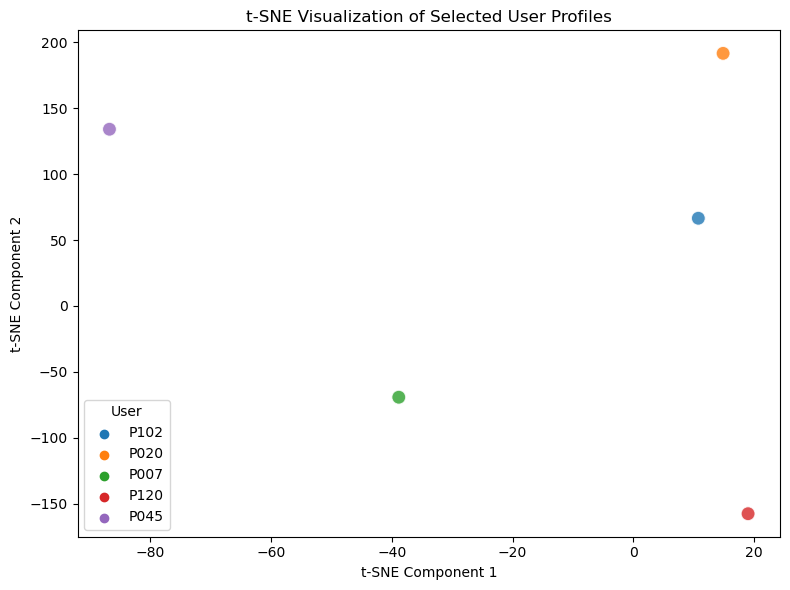

In [30]:
# from sklearn.manifold import TSNE

# # Prepare data for t-SNE
# X = selected_user_profiles.values

# # Initialize t-SNE
# tsne = TSNE(n_components=2, random_state=42, perplexity=3, n_iter=1000)

# # Fit and transform the data
# X_tsne = tsne.fit_transform(X)

# # Create a DataFrame for plotting
# tsne_df = pd.DataFrame({
#     'TSNE1': X_tsne[:, 0],
#     'TSNE2': X_tsne[:, 1],
#     'User': selected_user_profiles.index
# })

# # Plot t-SNE results
# plt.figure(figsize=(8, 6))
# sns.scatterplot(
#     x='TSNE1', y='TSNE2',
#     hue='User',
#     palette='viridis',
#     data=tsne_df,
#     s=100,
#     alpha=0.8
# )
# plt.title('t-SNE Visualization of Selected User Profiles')
# plt.xlabel('t-SNE Component 1')
# plt.ylabel('t-SNE Component 2')
# plt.legend(title='User')
# plt.tight_layout()
# plt.show()

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
import pandas as pd

# Prepare data for t-SNE
X = selected_user_profiles.values

# Initialize t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=3, n_iter=1000)

# Fit and transform the data
X_tsne = tsne.fit_transform(X)

# Create a DataFrame for plotting
tsne_df = pd.DataFrame({
    'TSNE1': X_tsne[:, 0],
    'TSNE2': X_tsne[:, 1],
    'User': selected_user_profiles.index
})

# Plot t-SNE results
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x='TSNE1', y='TSNE2',
    hue='User',
    palette='tab10',  # Changed palette from 'viridis' to 'coolwarm'
    data=tsne_df,
    s=100,
    alpha=0.8
)
plt.title('t-SNE Visualization of Selected User Profiles')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(title='User')
plt.tight_layout()
plt.show()



In [31]:
selected_user_profiles

,MSG#CNT_mean,MSG#CNT_std,MSG#CNT_sum,CALL#CNT_mean,CALL#CNT_std,CALL#CNT_sum,CALL#DUR_mean,CALL#DUR_std,CALL#DUR_sum
pcode,,,,,,,,,
P102,0.196106,0.764233,141.0,0.055633,0.316172,40.0,6.115438,49.260852,4397.0
P020,0.097842,0.451298,68.0,0.038849,0.239930,27.0,2.647482,25.762063,1840.0
P007,0.104874,0.506692,71.0,0.051699,0.310541,35.0,12.912851,191.898109,8742.0
P120,0.148048,0.672641,110.0,0.127860,0.504499,95.0,17.130552,187.393169,12728.0
P045,0.128593,0.533811,85.0,0.022693,0.176925,15.0,4.216339,44.155649,2787.0


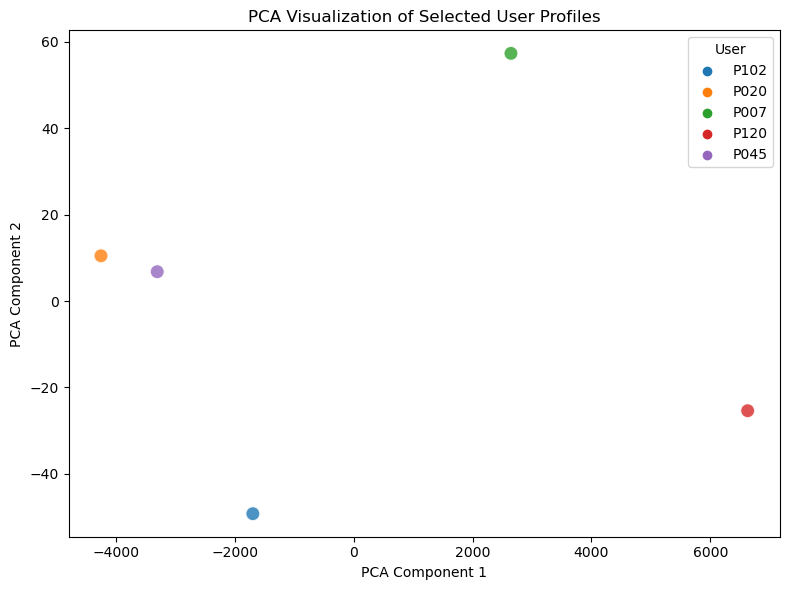

In [32]:
from sklearn.decomposition import PCA

# Initialize PCA
pca = PCA(n_components=2, random_state=42)

# Fit and transform the data
X_pca = pca.fit_transform(X)

# Create a DataFrame for plotting
pca_df = pd.DataFrame({
    'PCA1': X_pca[:, 0],
    'PCA2': X_pca[:, 1],
    'User': selected_user_profiles.index
})

# Plot PCA results
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x='PCA1', y='PCA2',
    hue='User',
    palette='tab10',
    data=pca_df,
    s=100,
    alpha=0.8
)
plt.title('PCA Visualization of Selected User Profiles')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='User')
plt.tight_layout()
plt.show()

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select features to plot (remove duplicates)
features_to_plot = [
    "MSG#CNT_mean",   
    "MSG#CNT_std",  
    "CALL#CNT_mean",
    "CALL#CNT_std",
    "CALL#DUR_mean",   
    "CALL#DUR_std",
]



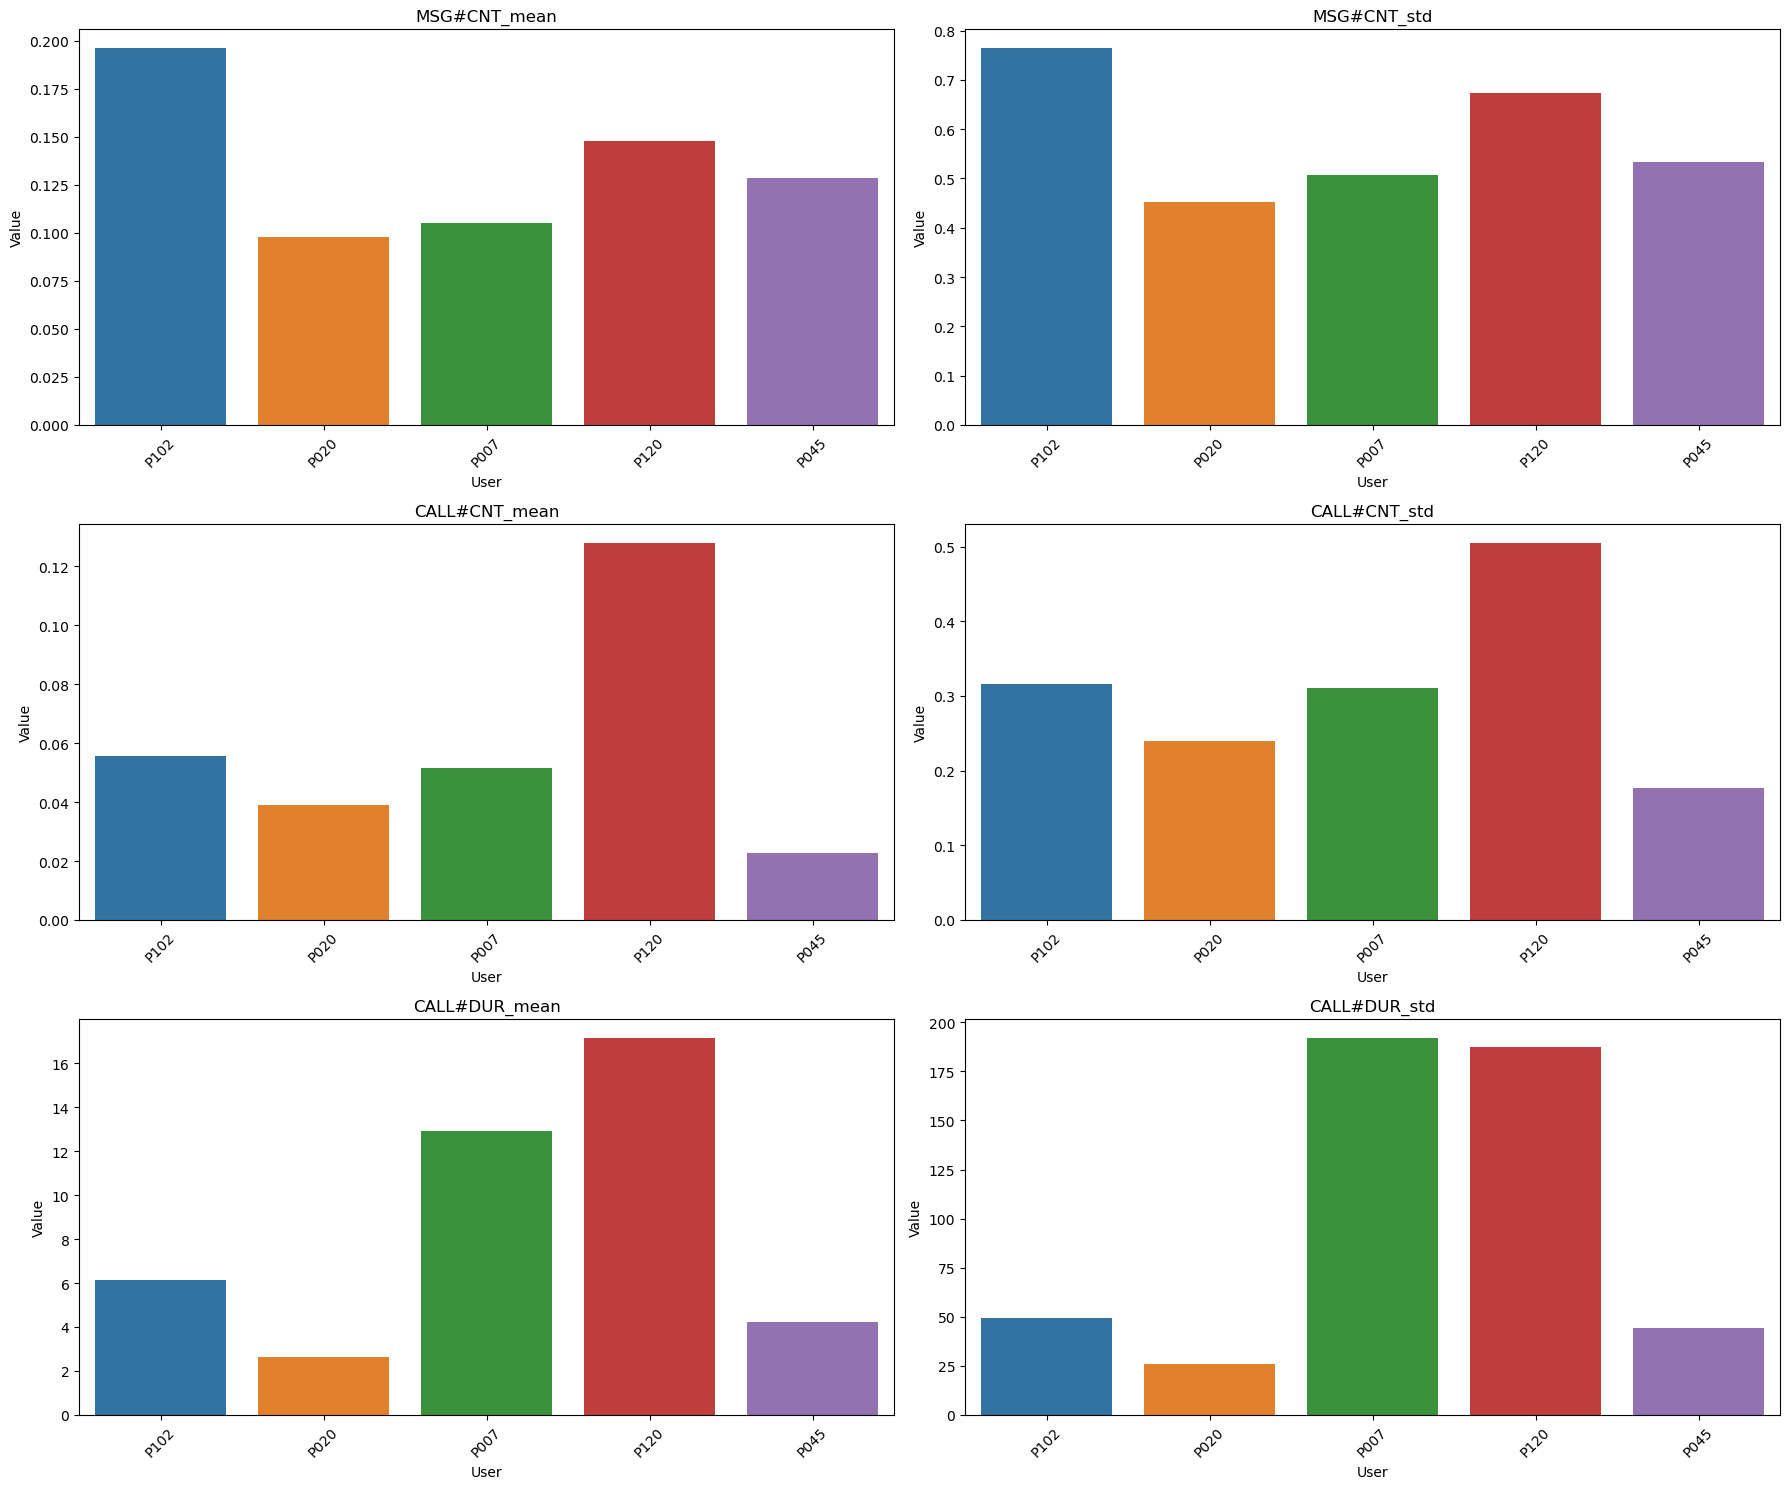

In [34]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# from sklearn.preprocessing import StandardScaler

# # Define features to plot (removing duplicates)
# features_to_plot = [
#     "MSG#CNT_mean",   
#     "MSG#CNT_std",  
#     "MSG#CNT_sum",  
#     "CALL#CNT_mean",
#     "CALL#CNT_std",
#     "CALL#CNT_sum",
#     "CALL#DUR_mean",   
#     "CALL#DUR_std",
#     "CALL#DUR_sum"
# ]

# # Create a copy of the selected user profiles DataFrame with only features to plot
# features_df = selected_user_profiles[features_to_plot]

# # Plot each feature in its own subplot
# num_features = len(features_to_plot)
# fig, axes = plt.subplots(num_features, 1, figsize=(10, num_features * 4), sharex=False)

# for i, feature in enumerate(features_to_plot):
#     sns.barplot(
#         x=selected_user_profiles.index,
#         y=feature,
#         data=features_df,
#         palette='viridis',
#         ax=axes[i]
#     )
#     axes[i].set_title(f'Feature: {feature}')
#     axes[i].set_xlabel('User')
#     axes[i].set_ylabel('Value')
#     axes[i].tick_params(axis='x', rotation=45)

# plt.tight_layout()
# plt.show()


import matplotlib.pyplot as plt
import seaborn as sns

# Define features to plot (removing duplicates)
features_to_plot = [
    "MSG#CNT_mean",
    "MSG#CNT_std",
    "CALL#CNT_mean",
    "CALL#CNT_std",
    "CALL#DUR_mean",
    "CALL#DUR_std"
]

# Create a copy of the selected user profiles DataFrame with only features to plot
features_df = selected_user_profiles[features_to_plot]

# Create a figure with 6 subplots arranged in a 3x2 format
fig, axes = plt.subplots(3, 2, figsize=(18, 15))

# Plot each feature in a separate subplot
for i, feature in enumerate(features_to_plot):
    row, col = divmod(i, 2)
    sns.barplot(x='pcode', y=feature, data=selected_user_profiles.reset_index(), ax=axes[row, col], palette='tab10')
    axes[row, col].set_title(feature)
    axes[row, col].set_xlabel('User')
    axes[row, col].set_ylabel('Value')
    axes[row, col].tick_params(axis='x', rotation=45)
    




# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()



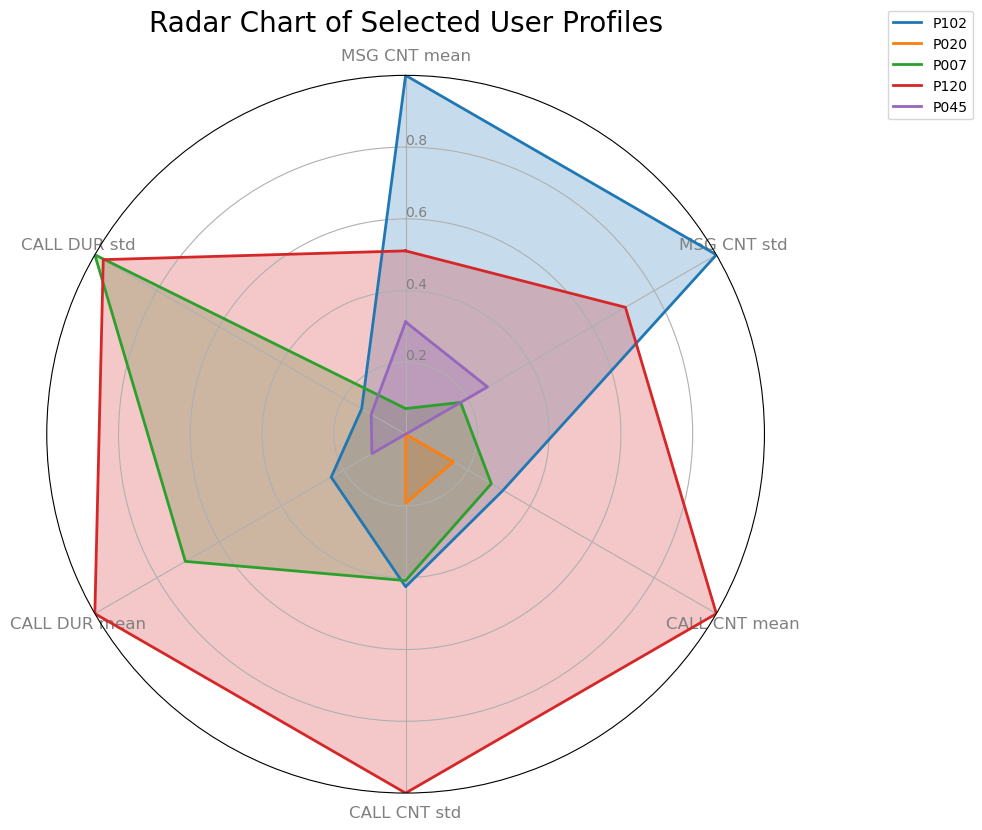

In [35]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

# Define features to plot (ensure the missing comma is added)
features_to_plot = [
    "MSG#CNT_mean",
    "MSG#CNT_std",
    "CALL#CNT_mean",
    "CALL#CNT_std",
    "CALL#DUR_mean",    # Added comma
    "CALL#DUR_std"
]

# Verify that all features exist in the selected_user_profiles
missing_features = [feature for feature in features_to_plot if feature not in selected_user_profiles.columns]
if missing_features:
    logger.warning(f"The following features are missing in the selected_user_profiles and will be skipped: {missing_features}")
    features_to_plot = [feature for feature in features_to_plot if feature in selected_user_profiles.columns]

# Extract the data for the radar chart
radar_data = selected_user_profiles[features_to_plot]

# Normalize the data for each feature to [0, 1] for better visualization
normalized_data = (radar_data - radar_data.min()) / (radar_data.max() - radar_data.min())

# Number of variables
num_vars = len(features_to_plot)

# Split the feature names to make them more readable (optional)
# For example, replace '#' with ' ' and '_' with ' '
feature_labels = [feature.replace('#', ' ').replace('_', ' ') for feature in features_to_plot]

# Calculate angle for each axis in the radar chart
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # Complete the loop

# Initialize the radar plot
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))

# Set the theta offset and direction
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)

# Draw one axis per variable + add labels
plt.xticks(angles[:-1], feature_labels, color='grey', size=12)

# Draw ylabels
ax.set_rlabel_position(0)
plt.yticks([0.2, 0.4, 0.6, 0.8], ["0.2", "0.4", "0.6", "0.8"], color="grey", size=10)
plt.ylim(0, 1)

# Plot each user
for idx, (user, row) in enumerate(normalized_data.iterrows()):
    values = row.tolist()
    values += values[:1]  # Complete the loop
    ax.plot(angles, values, linewidth=2, linestyle='solid', label=user)
    ax.fill(angles, values, alpha=0.25)

# Add a title
plt.title('Radar Chart of Selected User Profiles', size=20, y=1.05)

# Add a legend
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))

# Show the plot
plt.tight_layout()
plt.show()

# COHEN-D

In [43]:
features_df_imputed

MSG#CNT  CALL#CNT  CALL#DUR
pcode window_end_time                                              
P001  2021-11-23 14:39:19+09:00             8.0       0.0       0.0
      2021-11-23 15:39:19+09:00             0.0       0.0       0.0
      2021-11-23 16:39:19+09:00             0.0       0.0       0.0
      2021-11-23 17:39:19+09:00             0.0       0.0       0.0
      2021-11-23 18:39:19+09:00             0.0       0.0       0.0
...                                         ...       ...       ...
P135  2022-01-05 13:59:28.837000+09:00      0.0       0.0       0.0
      2022-01-05 14:59:28.837000+09:00      0.0       0.0       0.0
      2022-01-05 15:59:28.837000+09:00      0.0       0.0       0.0
      2022-01-05 16:59:28.837000+09:00      0.0       0.0       0.0
      2022-01-05 17:59:28.837000+09:00      0.0       0.0       0.0

[77962 rows x 3 columns]

In [53]:
# List of target pcode values
target_pcodes = ['P102', 'P020', 'P007', 'P120', 'P045']

# Filter the DataFrame for the specified pcode values
selected_users_df = features_df_imputed.loc[target_pcodes].reset_index()

# Display the new DataFrame
print(selected_users_df)



     pcode           window_end_time  MSG#CNT  CALL#CNT  CALL#DUR
0     P102 2021-12-02 12:59:21+09:00      2.0       0.0       0.0
1     P102 2021-12-02 13:59:21+09:00      0.0       0.0       0.0
2     P102 2021-12-02 14:59:21+09:00      0.0       0.0       0.0
3     P102 2021-12-02 15:59:21+09:00      0.0       0.0       0.0
4     P102 2021-12-02 16:59:21+09:00      2.0       0.0       0.0
...    ...                       ...      ...       ...       ...
3490  P045 2021-12-21 18:10:06+09:00      0.0       0.0       0.0
3491  P045 2021-12-21 19:10:06+09:00      0.0       0.0       0.0
3492  P045 2021-12-21 20:10:06+09:00      0.0       0.0       0.0
3493  P045 2021-12-21 21:10:06+09:00      0.0       0.0       0.0
3494  P045 2021-12-21 22:10:06+09:00      0.0       0.0       0.0

[3495 rows x 5 columns]


/tmp/ipykernel_128327/2029542337.py:21: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped_mean = normalized_df.groupby('pcode').mean()[columns_to_normalize]
/tmp/ipykernel_128327/2029542337.py:22: FutureWarning: The default value of numeric_only in DataFrameGroupBy.std is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped_std = normalized_df.groupby('pcode').std()[columns_to_normalize]


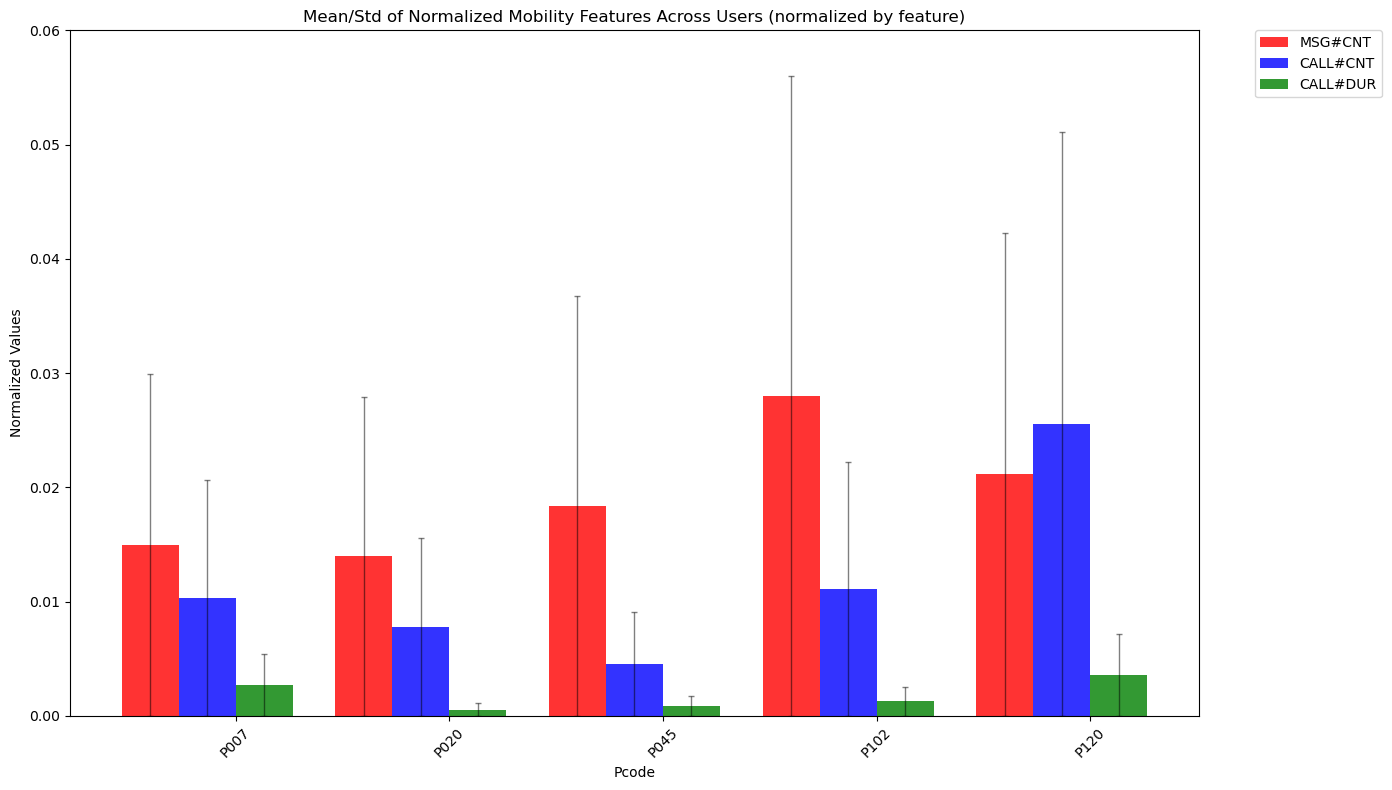

In [54]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import itertools

# Assuming selected_users_df is already defined

# Step 1: Normalize each column using Min-Max normalization
normalized_df = selected_users_df.copy()
columns_to_normalize = [
    "MSG#CNT",
    "CALL#CNT",
    "CALL#DUR"
]
for column in columns_to_normalize:
    min_val = selected_users_df[column].min()
    max_val = selected_users_df[column].max()
    normalized_df[column] = (selected_users_df[column] - min_val) / (max_val - min_val)

# Step 2: Group by 'pcode' and calculate mean and standard deviation for the normalized columns
grouped_mean = normalized_df.groupby('pcode').mean()[columns_to_normalize]
grouped_std = normalized_df.groupby('pcode').std()[columns_to_normalize]

# Step 3: Clip the lower bound of the error bars so they do not extend below zero
lower_bounds = grouped_mean - grouped_std
lower_bounds[lower_bounds < 0] = 0
adjusted_std = grouped_mean - lower_bounds

# Step 4: Define the plot size
fig, ax = plt.subplots(figsize=(14, 8))

# Step 5: Generate a large list of distinguishable colors
colors = itertools.cycle([
    'red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan', 
    'navy', 'magenta', 'gold', 'lime', 'teal'
])

# Step 6: Plot mean values with improved error bars for each column, using distinct colors
bar_width = 0.8 / len(columns_to_normalize)  # Adjust bar width to fit all columns
x = np.arange(len(grouped_mean.index))  # x positions for the groups

for idx, column in enumerate(columns_to_normalize):
    color = next(colors)  # Get the next color from the cycle
    # Plot the mean bars
    ax.bar(x + idx * bar_width, grouped_mean[column], width=bar_width, label=column, color=color, alpha=0.8)
    # Add error bars with a dotted line style
    ax.errorbar(x + idx * bar_width, grouped_mean[column], yerr=adjusted_std[column], fmt='none',
                ecolor='black', elinewidth=1, linestyle=':', capsize=2, alpha=0.5)


# Step 7: Set labels, title, and legend (legend positioned outside the figure)
ax.set_xlabel("Pcode")
ax.set_ylabel("Normalized Values")
ax.set_title("Mean/Std of Normalized Mobility Features Across Users (normalized by feature)")

# Configure y-axis
ax.set_ylim(0, 0.06)  # Set y-axis range from 0 to 1 for normalized values


# Set xticks at the center of grouped bars
ax.set_xticks(x + bar_width * (len(columns_to_normalize) / 2))
ax.set_xticklabels(grouped_mean.index, rotation=45)

# Place legend outside the plot
ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)

# Step 8: Adjust layout and show the plot
plt.tight_layout()
plt.show()


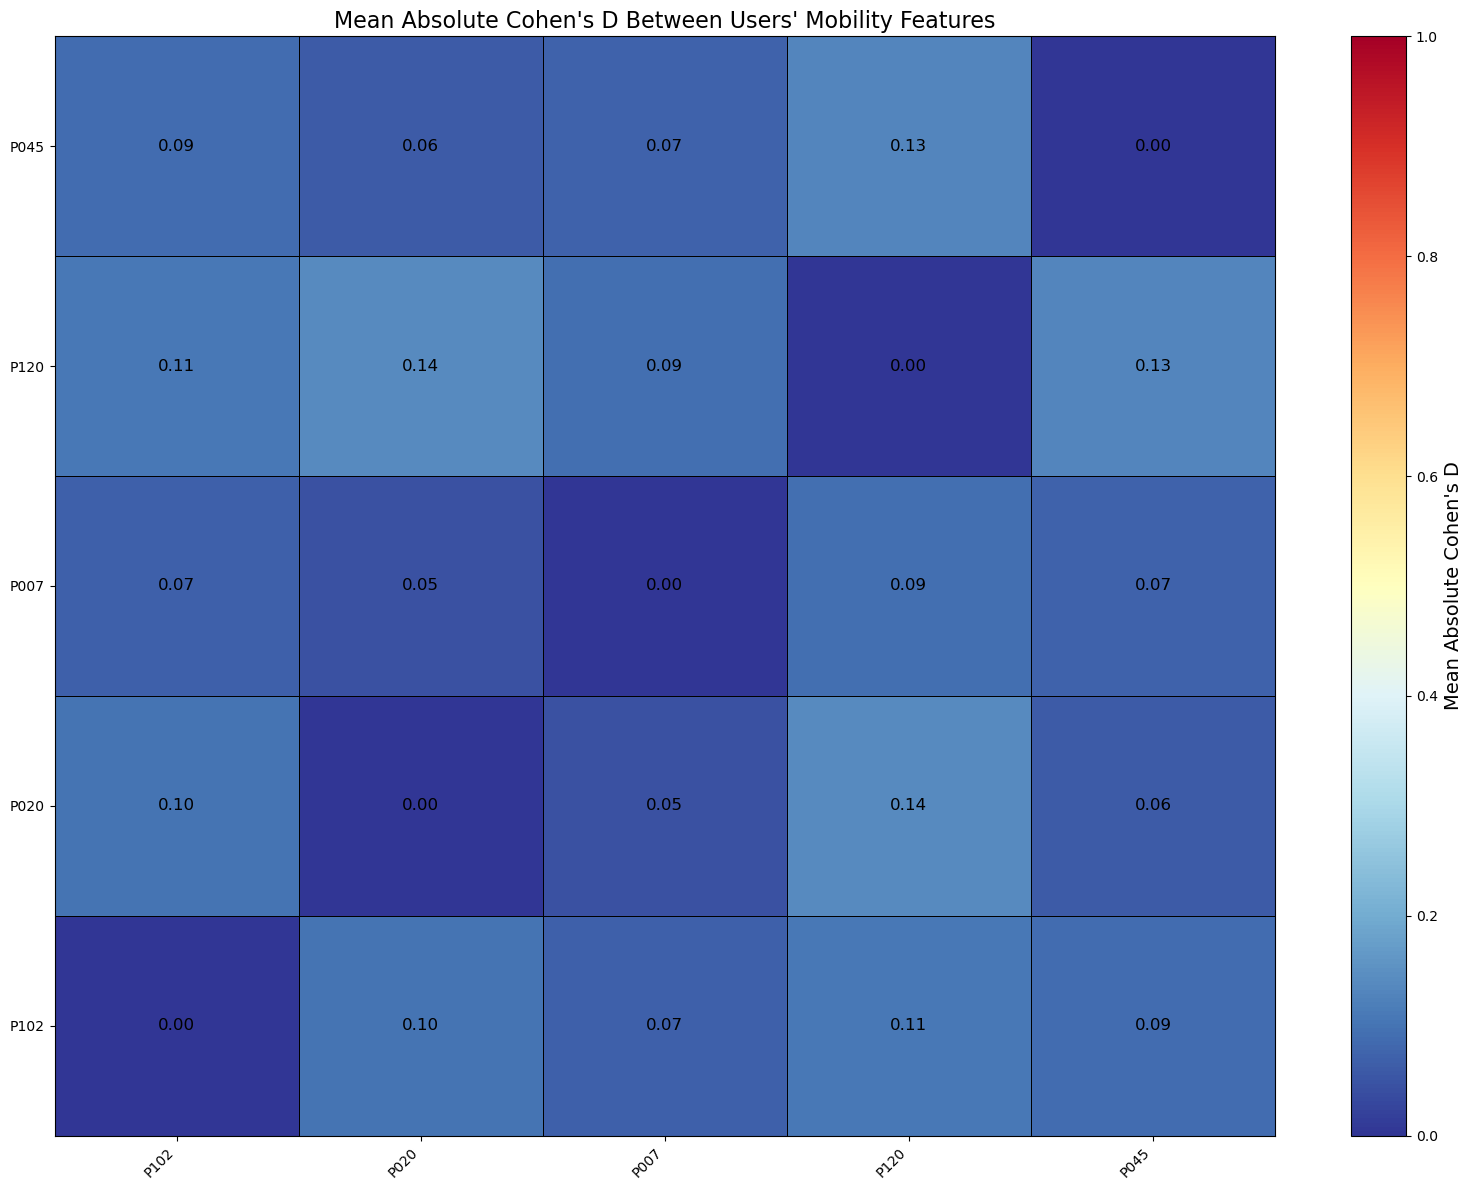

In [55]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt

# Assuming selected_users_df is already defined and 'PCode' is the user identifier

# Define the columns to be used for calculating Cohen's D
selected_columns = [
    "MSG#CNT",
    "CALL#CNT",
    "CALL#DUR"
]

# Step 1: Create a function to calculate absolute Cohen's D
def cohen_d(x1, x2):
    x1 = x1.dropna()
    x2 = x2.dropna()
    n1, n2 = len(x1), len(x2)
    if n1 < 2 or n2 < 2:
        return np.nan
    mean1, mean2 = x1.mean(), x2.mean()
    var1, var2 = x1.var(ddof=1), x2.var(ddof=1)
    pooled_std = np.sqrt(
        ((n1 - 1) * var1 + (n2 - 1) * var2) / (n1 + n2 - 2)
    )
    if pooled_std == 0:
        return np.nan
    else:
        return abs((mean1 - mean2) / pooled_std)

# Step 2: Extract unique user codes and initialize a matrix for mean absolute Cohen's D values
user_codes = selected_users_df['pcode'].unique()  # Updated column name
cohen_d_matrix = pd.DataFrame(index=user_codes, columns=user_codes)

# Step 3: Calculate mean absolute Cohen's D for each pair of users across selected columns
for user1, user2 in itertools.product(user_codes, repeat=2):
    if user1 == user2:
        cohen_d_matrix.loc[user1, user2] = 0  # Diagonal set to zero
        continue
    data1 = selected_users_df[selected_users_df['pcode'] == user1][selected_columns]
    data2 = selected_users_df[selected_users_df['pcode'] == user2][selected_columns]
    
    d_values = []
    for column in selected_columns:
        d = cohen_d(data1[column], data2[column])
        if not np.isnan(d):
            d_values.append(d)
    # Compute mean absolute Cohen's D
    if len(d_values) > 0:
        mean_d = np.mean(d_values)
    else:
        mean_d = np.nan
    cohen_d_matrix.loc[user1, user2] = mean_d

# Convert to numeric
cohen_d_matrix = cohen_d_matrix.apply(pd.to_numeric, errors='coerce')

# Replace infinite values
cohen_d_matrix.replace([np.inf, -np.inf], np.nan, inplace=True)

# Ensure all values are non-negative (since we took absolute values)
cohen_d_matrix = cohen_d_matrix.abs()

# Step 4: Set the diagonal values explicitly to 0
np.fill_diagonal(cohen_d_matrix.values, 0)

# Step 5: Create a heatmap using Matplotlib's `pcolormesh()`
data = cohen_d_matrix.values
labels = cohen_d_matrix.index

fig, ax = plt.subplots(figsize=(16, 12))

# Define the color map and draw the heatmap using `pcolormesh`
vmin, vmax = 0, 1  # Set fixed range for Cohen's D thresholds
cmap = plt.get_cmap('RdYlBu_r')  # Vibrant color map for better contrast
heatmap = ax.pcolormesh(data, cmap=cmap, edgecolors='k', linewidth=0.5, vmin=vmin, vmax=vmax)

# Add color bar
cbar = plt.colorbar(heatmap)
cbar.set_label("Mean Absolute Cohen's D", fontsize=14)

# Set axis labels and ticks
ax.set_xticks(np.arange(data.shape[1]) + 0.5)
ax.set_yticks(np.arange(data.shape[0]) + 0.5)
ax.set_xticklabels(labels, rotation=45, ha='right', fontsize=10)
ax.set_yticklabels(labels, fontsize=10)

# Annotate each cell with the value from `cohen_d_matrix`
for i in range(data.shape[0]):
    for j in range(data.shape[1]):
        ax.text(j + 0.5, i + 0.5, f'{data[i, j]:.2f}', 
                ha='center', va='center', color='black', fontsize=12)

# Set title and layout
plt.title("Mean Absolute Cohen's D Between Users' Mobility Features", fontsize=16)
plt.tight_layout()
plt.show()


previous

In [ ]:
import numpy as np

def cohens_d(group_a: np.ndarray, group_b: np.ndarray) -> float:
    """
    Calculate Cohen's d for the difference between two groups.

    Parameters:
    - group_a: Array-like, data for group A.
    - group_b: Array-like, data for group B.

    Returns:
    - d: Cohen's d value.
    """
    # Calculate the means of the groups
    mean_a = np.mean(group_a)
    mean_b = np.mean(group_b)
    
    # Calculate the standard deviations of the groups
    std_a = np.std(group_a, ddof=1)
    std_b = np.std(group_b, ddof=1)
    
    # Calculate the pooled standard deviation
    pooled_std = np.sqrt(((std_a ** 2) + (std_b ** 2)) / 2)
    
    # Handle the case where pooled_std is zero to avoid division by zero
    if pooled_std == 0:
        return 0.0
    
    # Calculate Cohen's d
    d = (mean_a - mean_b) / pooled_std
    return d

In [ ]:
# Reset the index to have 'pcode' as a column
features_df_reset = features_df_imputed.reset_index()

# Display the first few rows to verify
print(features_df_reset.head())

In [ ]:
import pandas as pd
from itertools import combinations

# Define the list of selected users
selected_users = ['P102', 'P020', 'P007', 'P120', 'P045']

# Define the features to analyze
features_to_analyze = [
    "MSG#CNT",
    "CALL#CNT",
    "CALL#DUR"
]

# Initialize a list to store the results
cohens_d_results = []

# Iterate through each selected user
for user in selected_users:
    for feature in features_to_analyze:
        # Group A: Data for the current user
        group_a = features_df_reset[features_df_reset['pcode'] == user][feature].dropna().values
        
        # Group B: Data for all other users
        group_b = features_df_reset[features_df_reset['pcode'] != user][feature].dropna().values
        
        # Compute Cohen's d
        d = cohens_d(group_a, group_b)
        
        # Append the result
        cohens_d_results.append({
            'User': user,
            'Feature': feature,
            "Cohen's d": d
        })

# Convert the results to a DataFrame
cohens_d_df = pd.DataFrame(cohens_d_results)

# Display the Cohen's d results
print(cohens_d_df)


In [ ]:
# Pivot the DataFrame
cohens_d_pivot = cohens_d_df.pivot(index='User', columns='Feature', values="Cohen's d")

# Display the pivoted DataFrame
print(cohens_d_pivot)


In [ ]:
# Melt the pivoted DataFrame for easier plotting with seaborn
cohens_d_melted = cohens_d_pivot.reset_index().melt(id_vars='User', var_name='Feature', value_name="Cohen's d")

# Set the plot size
plt.figure(figsize=(14, 8))

# Create a bar plot
sns.barplot(x='Feature', y="Cohen's d", hue='User', data=cohens_d_melted, palette='Set2')

# Customize the plot
plt.title("Cohen's d Effect Sizes Across Features for Selected Users")
plt.xlabel("Features")
plt.ylabel("Cohen's d")
plt.legend(title='User', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()


# Hourly Visulization

In [ ]:
# Assuming all previous imports and preprocessing have been done
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

# Define the relevant features
relevant_features = ['MSG#CNT', 'CALL#CNT', 'CALL#DUR']

# Ensure these features exist in features_df_imputed
missing_features = [feature for feature in relevant_features if feature not in features_df_imputed.columns]
if missing_features:
    logger.error(f"The following required features are missing: {missing_features}")
    raise ValueError(f"Missing features: {missing_features}")

# Extract the hourly data for PCA and t-SNE
hourly_data = features_df_imputed[relevant_features].copy()
hourly_data.reset_index(inplace=True)  # Make 'pcode' and 'window_end_time' columns

# Check for any remaining missing values
if hourly_data[relevant_features].isnull().any().any():
    logger.warning("Missing values detected in hourly_data. Imputing with 0.")
    hourly_data[relevant_features] = hourly_data[relevant_features].fillna(0)

# Feature scaling
scaler = StandardScaler()
scaled_features = scaler.fit_transform(hourly_data[relevant_features])

# Add scaled features to a new DataFrame
scaled_df = pd.DataFrame(scaled_features, columns=relevant_features)
scaled_df['pcode'] = hourly_data['pcode'].values
scaled_df['window_end_time'] = hourly_data['window_end_time'].values

# Prepare data for PCA and t-SNE
X = scaled_df[relevant_features].values
y = scaled_df['pcode'].values  # User labels

# Conduct PCA
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X)
pca_df = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
pca_df['User'] = y

# Conduct t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=1000, init='pca')
X_tsne = tsne.fit_transform(X)
tsne_df = pd.DataFrame(data=X_tsne, columns=['TSNE1', 'TSNE2'])
tsne_df['User'] = y

# Visualize PCA Results
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='PC1', y='PC2',
    hue='User',
    palette='tab10',
    data=pca_df,
    alpha=0.6
)
plt.title('PCA of Hourly User Data')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.2f}% Variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.2f}% Variance)')
plt.legend(title='User', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Visualize t-SNE Results
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='TSNE1', y='TSNE2',
    hue='User',
    palette='tab10',
    data=tsne_df,
    alpha=0.6
)
plt.title('t-SNE of Hourly User Data')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(title='User', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Optional: Combined PCA and t-SNE Plot
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# PCA Plot
sns.scatterplot(
    x='PC1', y='PC2',
    hue='User',
    palette='tab10',
    data=pca_df,
    alpha=0.6,
    ax=axes[0]
)
axes[0].set_title('PCA of Hourly User Data')
axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.2f}% Variance)')
axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.2f}% Variance)')

# t-SNE Plot
sns.scatterplot(
    x='TSNE1', y='TSNE2',
    hue='User',
    palette='tab10',
    data=tsne_df,
    alpha=0.6,
    ax=axes[1]
)
axes[1].set_title('t-SNE of Hourly User Data')
axes[1].set_xlabel('t-SNE Component 1')
axes[1].set_ylabel('t-SNE Component 2')

# Adjust legends
for ax in axes:
    ax.legend(title='User', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import random
import matplotlib.dates as mdates
import logging
from typing import List

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler("user_profile.log"),
        logging.StreamHandler()
    ]
)
logger = logging.getLogger()

# Define the relevant features to plot
relevant_features = ['MSG#CNT', 'CALL#CNT', 'CALL#DUR']

# Ensure these features exist in features_df_imputed
missing_features = [feature for feature in relevant_features if feature not in features_df_imputed.columns]
if missing_features:
    logger.error(f"The following required features are missing: {missing_features}")
    raise ValueError(f"Missing features: {missing_features}")

# Select 5 users for comparison
unique_users = user_profiles.index.tolist()

# Extract profiles of selected users (if needed for further analysis)
selected_user_profiles = user_profiles.loc[selected_users]
logger.info(f"\nSelected User Profiles:\n{selected_user_profiles.head()}")

# Reset index to access 'pcode' and 'window_end_time' as columns
features_df_imputed_reset = features_df_imputed.reset_index()

# Filter the hourly data for selected users
filtered_hourly_data = features_df_imputed_reset[features_df_imputed_reset['pcode'].isin(selected_users)].copy()

# Sort the data by 'window_end_time' to ensure chronological order
filtered_hourly_data.sort_values(by=['window_end_time'], inplace=True)

# Ensure 'window_end_time' is in datetime format
if not pd.api.types.is_datetime64_any_dtype(filtered_hourly_data['window_end_time']):
    filtered_hourly_data['window_end_time'] = pd.to_datetime(filtered_hourly_data['window_end_time'])

# Set up the color palette using a colorblind-friendly palette
palette = sns.color_palette("Set2", n_colors=len(selected_users))
palette_dict = dict(zip(selected_users, palette))

# Define plot size and style
sns.set(style="whitegrid")
plt.rcParams.update({
    'font.size': 14,
    'axes.titlesize': 16,
    'axes.labelsize': 14,
    'legend.fontsize': 12,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12
})

# Create a figure with separate subplots for each feature
fig, axes = plt.subplots(len(relevant_features), 1, figsize=(15, 5 * len(relevant_features)), sharex=True)

# Iterate through each feature and create a separate line plot
for idx, feature in enumerate(relevant_features):
    ax = axes[idx]
    for user in selected_users:
        user_data = filtered_hourly_data[filtered_hourly_data['pcode'] == user]
        ax.plot(
            user_data['window_end_time'],
            user_data[feature],
            label=user,
            marker='o',
            linestyle='-',
            linewidth=2,
            markersize=6,
            color=palette_dict[user]
        )
    
    # Set title and labels
    ax.set_title(f'Hourly {feature} Across Users', fontsize=16, fontweight='bold')
    ax.set_ylabel(f'{feature} Value', fontsize=14)
    
    # Format x-axis dates
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
    ax.tick_params(axis='x', rotation=45)
    
    # Set y-axis limits based on feature
    y_min = filtered_hourly_data[feature].min() * 0.95
    y_max = filtered_hourly_data[feature].max() * 1.05
    ax.set_ylim(y_min, y_max)
    
    # Add legend
    ax.legend(title='User', loc='upper left', bbox_to_anchor=(1.02, 1))
    
    # Add grid for better readability
    ax.grid(True, linestyle='--', alpha=0.6)

# Set common x-axis label
axes[-1].set_xlabel('Timestamp', fontsize=14)

# Adjust layout to prevent overlapping elements
plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust rect to make space for legends

# Add a main title for the entire figure
plt.suptitle('Hourly Feature Trends Across Selected Users', fontsize=20, fontweight='bold', y=1.02)

# Show the plot
plt.show()


In [ ]:
# Assuming all previous imports and preprocessing have been done
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import logging

# Configure logging (ensure this is done at the beginning of your script)
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler("user_profile.log"),
        logging.StreamHandler()
    ]
)
logger = logging.getLogger()

# Define the relevant features
relevant_features = ['MSG#CNT', 'CALL#CNT', 'CALL#DUR']

# Ensure these features exist in features_df_imputed
missing_features = [feature for feature in relevant_features if feature not in features_df_imputed.columns]
if missing_features:
    logger.error(f"The following required features are missing: {missing_features}")
    raise ValueError(f"Missing features: {missing_features}")

# Select 5 users for comparison
unique_users = user_profiles.index.tolist()

# Extract profiles of selected users
selected_user_profiles = user_profiles.loc[selected_users]
logger.info(f"\nSelected User Profiles:\n{selected_user_profiles.head()}")

# Reset index to access 'pcode' and 'window_end_time' as columns
features_df_imputed_reset = features_df_imputed.reset_index()

# Filter the hourly data for selected users
filtered_hourly_data = features_df_imputed_reset[features_df_imputed_reset['pcode'].isin(selected_users)].copy()

# Sort the data by 'window_end_time' to ensure chronological order
filtered_hourly_data.sort_values(by=['window_end_time'], inplace=True)

# Ensure 'window_end_time' is in datetime format
if not pd.api.types.is_datetime64_any_dtype(filtered_hourly_data['window_end_time']):
    filtered_hourly_data['window_end_time'] = pd.to_datetime(filtered_hourly_data['window_end_time'])

# Extract the hourly data for PCA and t-SNE
hourly_data = filtered_hourly_data[relevant_features].copy()
hourly_data.reset_index(drop=True, inplace=True)  # Reset index after filtering

# Check for any remaining missing values
if hourly_data[relevant_features].isnull().any().any():
    logger.warning("Missing values detected in hourly_data. Imputing with 0.")
    hourly_data[relevant_features] = hourly_data[relevant_features].fillna(0)

# Feature scaling
scaler = StandardScaler()
scaled_features = scaler.fit_transform(hourly_data[relevant_features])

# Add scaled features to a new DataFrame
scaled_df = pd.DataFrame(scaled_features, columns=relevant_features)
scaled_df['pcode'] = filtered_hourly_data['pcode'].values
scaled_df['window_end_time'] = filtered_hourly_data['window_end_time'].values

# Prepare data for PCA and t-SNE
X = scaled_df[relevant_features].values
y = scaled_df['pcode'].values  # User labels

# Conduct PCA
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X)
pca_df = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
pca_df['User'] = y

# Conduct t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=1000, init='pca')
X_tsne = tsne.fit_transform(X)
tsne_df = pd.DataFrame(data=X_tsne, columns=['TSNE1', 'TSNE2'])
tsne_df['User'] = y

# Visualize PCA Results
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x='PC1', y='PC2',
    hue='User',
    palette='tab10',
    data=pca_df,
    alpha=0.7,
    edgecolor='k',
    s=100
)
plt.title('PCA of Hourly User Data', fontsize=18, fontweight='bold')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.2f}% Variance)', fontsize=14)
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.2f}% Variance)', fontsize=14)
plt.legend(title='User', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12, title_fontsize=14)
plt.tight_layout()
plt.show()

# Visualize t-SNE Results
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x='TSNE1', y='TSNE2',
    hue='User',
    palette='tab10',
    data=tsne_df,
    alpha=0.7,
    edgecolor='k',
    s=100
)
plt.title('t-SNE of Hourly User Data', fontsize=18, fontweight='bold')
plt.xlabel('t-SNE Component 1', fontsize=14)
plt.ylabel('t-SNE Component 2', fontsize=14)
plt.legend(title='User', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12, title_fontsize=14)
plt.tight_layout()
plt.show()

# Optional: Combined PCA and t-SNE Plot
fig, axes = plt.subplots(1, 2, figsize=(24, 10))

# PCA Plot
sns.scatterplot(
    x='PC1', y='PC2',
    hue='User',
    palette='tab10',
    data=pca_df,
    alpha=0.7,
    edgecolor='k',
    s=100,
    ax=axes[0]
)
axes[0].set_title('PCA of Hourly User Data', fontsize=18, fontweight='bold')
axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.2f}% Variance)', fontsize=14)
axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.2f}% Variance)', fontsize=14)
axes[0].legend(title='User', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12, title_fontsize=14)

# t-SNE Plot
sns.scatterplot(
    x='TSNE1', y='TSNE2',
    hue='User',
    palette='tab10',
    data=tsne_df,
    alpha=0.7,
    edgecolor='k',
    s=100,
    ax=axes[1]
)
axes[1].set_title('t-SNE of Hourly User Data', fontsize=18, fontweight='bold')
axes[1].set_xlabel('t-SNE Component 1', fontsize=14)
axes[1].set_ylabel('t-SNE Component 2', fontsize=14)
axes[1].legend(title='User', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12, title_fontsize=14)

plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import random
import matplotlib.dates as mdates
import logging
from typing import List
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

# Configure logging (ensure this is done at the beginning of your script)
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler("user_profile.log"),
        logging.StreamHandler()
    ]
)
logger = logging.getLogger()

# Define the relevant features to plot
relevant_features = ['MSG#CNT', 'CALL#CNT', 'CALL#DUR']

# Ensure these features exist in features_df_imputed
missing_features = [feature for feature in relevant_features if feature not in features_df_imputed.columns]
if missing_features:
    logger.error(f"The following required features are missing: {missing_features}")
    raise ValueError(f"Missing features: {missing_features}")

# Select 5 users for comparison
unique_users = user_profiles.index.tolist()

# Extract profiles of selected users
selected_user_profiles = user_profiles.loc[selected_users]
logger.info(f"\nSelected User Profiles:\n{selected_user_profiles.head()}")

# Reset index to access 'pcode' and 'window_end_time' as columns
features_df_imputed_reset = features_df_imputed.reset_index()

# Filter the hourly data for selected users
filtered_hourly_data = features_df_imputed_reset[features_df_imputed_reset['pcode'].isin(selected_users)].copy()

# Sort the data by 'window_end_time' to ensure chronological order
filtered_hourly_data.sort_values(by=['window_end_time'], inplace=True)

# Ensure 'window_end_time' is in datetime format
if not pd.api.types.is_datetime64_any_dtype(filtered_hourly_data['window_end_time']):
    filtered_hourly_data['window_end_time'] = pd.to_datetime(filtered_hourly_data['window_end_time'])

# ------------------ Daily Aggregation Step ------------------

# Create a 'date' column by extracting the date from 'window_end_time'
filtered_hourly_data['date'] = filtered_hourly_data['window_end_time'].dt.date

# Group by 'pcode' and 'date', then calculate the mean for each feature
daily_aggregated_data = filtered_hourly_data.groupby(['pcode', 'date'])[relevant_features].mean().reset_index()

# Convert 'date' back to datetime for plotting
daily_aggregated_data['date'] = pd.to_datetime(daily_aggregated_data['date'])

# ------------------ End of Aggregation ------------------

# Log the head of the aggregated data for verification
logger.info(f"\nDaily Aggregated User Profiles:\n{daily_aggregated_data.head()}")

# Feature scaling
scaler = StandardScaler()
scaled_features = scaler.fit_transform(daily_aggregated_data[relevant_features])

# Add scaled features to a new DataFrame
scaled_df = pd.DataFrame(scaled_features, columns=relevant_features)
scaled_df['pcode'] = daily_aggregated_data['pcode'].values
scaled_df['date'] = daily_aggregated_data['date'].values

# Prepare data for LDA
X = scaled_df[relevant_features].values
y = scaled_df['pcode'].values  # User labels

# Conduct LDA
lda = LDA(n_components=2)
X_lda = lda.fit_transform(X, y)
lda_df = pd.DataFrame(data=X_lda, columns=['LD1', 'LD2'])
lda_df['User'] = y

# ------------------ Visualization: LDA Results ------------------
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x='LD1', y='LD2',
    hue='User',
    palette='tab10',
    data=lda_df,
    alpha=0.7,
    edgecolor='k',
    s=100
)
plt.title('LDA of Daily Aggregated User Data', fontsize=18, fontweight='bold')
plt.xlabel(f'LD1', fontsize=14)
plt.ylabel(f'LD2', fontsize=14)
plt.legend(title='User', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12, title_fontsize=14)
plt.tight_layout()
plt.show()


In [ ]:
# ------------------ Visualization: Small Multiples Line Plots ------------------

# Set up the color palette using a colorblind-friendly palette
palette = sns.color_palette("Set2", n_colors=len(selected_users))
palette_dict = dict(zip(selected_users, palette))

# Define plot size and style
sns.set(style="whitegrid")
plt.rcParams.update({
    'font.size': 14,
    'axes.titlesize': 16,
    'axes.labelsize': 14,
    'legend.fontsize': 12,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12
})

# Determine the grid size for subplots (e.g., 1 row x 3 columns for 3 features)
cols = 3
rows = 1  # Single row since there are 3 features

# Create subplots
fig, axes = plt.subplots(rows, cols, figsize=(20, 6), sharey=False)

# Flatten axes array for easy iteration (in case of multiple rows)
axes = axes.flatten()

# Iterate through each feature and create a separate line plot
for idx, feature in enumerate(relevant_features):
    ax = axes[idx]
    for user in selected_users:
        user_data = daily_aggregated_data[daily_aggregated_data['pcode'] == user]
        ax.plot(
            user_data['date'],
            user_data[feature],
            label=user,
            marker='o',
            linestyle='-',
            linewidth=2,
            markersize=6,
            color=palette_dict[user]
        )
    
    # Set title and labels
    ax.set_title(f'Daily Mean {feature} Across Users', fontsize=16, fontweight='bold')
    ax.set_ylabel(f'{feature} Mean Value', fontsize=14)
    
    # Format x-axis dates for better readability
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax.tick_params(axis='x', rotation=45)
    
    # Set y-axis limits based on feature to ensure consistency
    y_min = daily_aggregated_data[feature].min() * 0.95
    y_max = daily_aggregated_data[feature].max() * 1.05
    ax.set_ylim(y_min, y_max)
    
    # Add legend outside the plot area to prevent overlap
    ax.legend(title='User', loc='upper left', bbox_to_anchor=(1.02, 1))
    
    # Add grid for better readability
    ax.grid(True, linestyle='--', alpha=0.6)

# Set common x-axis label
axes[-1].set_xlabel('Date', fontsize=14)

# Adjust layout to prevent overlapping elements and make space for legends
plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust rect to make space for legends

# Add a main title for the entire figure
plt.suptitle('Daily Aggregated Feature Trends Across Selected Users', fontsize=20, fontweight='bold', y=1.02)

# Show the plot
plt.show()

# ------------------ End of Small Multiples Visualization ------------------


In [ ]:
# ------------------ Visualization: Separate Line Plots for Each Feature ------------------

# Set up the color palette using a colorblind-friendly palette
palette = sns.color_palette("Set2", n_colors=len(selected_users))
palette_dict = dict(zip(selected_users, palette))

# Define plot style
sns.set(style="whitegrid")
plt.rcParams.update({
    'font.size': 14,
    'axes.titlesize': 16,
    'axes.labelsize': 14,
    'legend.fontsize': 12,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12
})

# Iterate through each feature and create a separate line plot
for feature in relevant_features:
    # Create a new figure for each feature
    plt.figure(figsize=(10, 6))

    for user in selected_users:
        user_data = daily_aggregated_data[daily_aggregated_data['pcode'] == user]
        plt.plot(
            user_data['date'],
            user_data[feature],
            label=user,
            marker='o',
            linestyle='-',
            linewidth=2,
            markersize=6,
            color=palette_dict[user]
        )

    # Set title and labels
    plt.title(f'Daily Mean {feature} Across Users', fontsize=16, fontweight='bold')
    plt.ylabel(f'{feature} Mean Value', fontsize=14)
    plt.xlabel('Date', fontsize=14)

    # Format x-axis dates for better readability
    plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.xticks(rotation=45)

    # Set y-axis limits based on feature to ensure consistency
    y_min = daily_aggregated_data[feature].min() * 0.95
    y_max = daily_aggregated_data[feature].max() * 1.05
    plt.ylim(y_min, y_max)

    # Add legend outside the plot area to prevent overlap
    plt.legend(title='User', loc='upper left', bbox_to_anchor=(1.02, 1))

    # Add grid for better readability
    plt.grid(True, linestyle='--', alpha=0.6)

    # Adjust layout to prevent overlapping elements
    plt.tight_layout(rect=[0, 0, 0.85, 1])

    # Show the plot
    plt.show()